## Moment-Curvature Analysis

1472.6215563702156
[[0, 0], [400, 0], [400, 600], [0, 600]]
[[10, 10], [390, 10], [390, 590], [10, 590]]
[[200.0, 0, 1472.6215563702156]]
[30, 0.0021000000000000003, 25.5, 0.0035]
[30, 0.0021000000000000003, 25.5, 0.0035]
[420, 1e-06, 0.02]


C:\Users\alber\AppData\Local\Temp\ipykernel_39340\3255218411.py:338: RuntimeWarning: invalid value encountered in double_scalars
  xNew = x-F/derivati


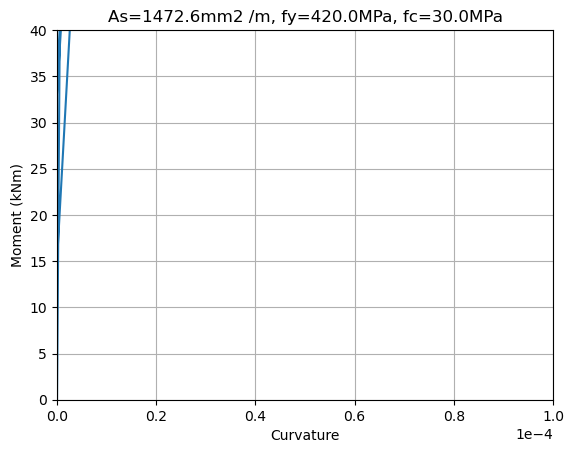

In [20]:
# -*- coding: utf-8 -*-
"""
Created on Sun Apr  4 20:44:20 2021
@author: Brisid
"""

import numpy as np
from random import randrange
import math

def steelStress(x, fy, eu, bsteel):
        #Define steel:
            
        E = 200000
        ey = fy/E
        sign=np.sign(x)
        
        if abs(x)<=ey:
            f = sign*x*E
        elif abs(x)>ey:
            if abs(x)>eu:
                f=0
            else:
                f = fy+bsteel*E*(abs(x)-ey)
        return f*sign

def concreteStress(x, fc, ec0, fcu, ecu):
    #Define concrete here.
    #E = 1000*22*(0.1*fc)**0.3

    if x>=0:
         f=0
         
    if x<=-ecu:
         f=-0
        
    if x>-ecu and x<=-ec0:
         f = -fcu + (abs(ecu)-abs(x))*(fc-fcu)/(ec0-ecu)
         
    if x>-ec0 and x<0:
         f = -fc*(2*abs(x)/ec0-(abs(x)/ec0)*(abs(x)/ec0))
    return f
    

def epsilon(h, x, yi, etop):
    
    eci = etop - etop*(h-yi)/x
    return eci
    

def momentCurvature(section, coreSection, steelBars, concreteUC, concreteC, steel, N, steps, tol, maxIterations, noFibresCore, noFibresCover):
    '''
    Calculates the moment - curvature relationship of a rectangular reinforced concrete section.

    Parameters
    ----------
    section : List of lists of floats
        Coordinates of the RECTANGULAR cross section [[x1, y1], [x2, y2], ...].
    coreSection : List of lists of floats
        Coordinates of the cross section of confined core [[x1, y1], [x2, y2], ...].
    steelBars : List of lists of floats
        Coordinates and area of the bar [[x1, y1, As1], [x2, y2, As2], ...].
    concreteUC : List of floats
        Cnconfined concrete [fc, ec0, fcu, ecu].
    concreteC : List of floats
        confined concrete [fc, ec0, fcu, ecu,].
    steel : List of floats
        Steel properties [fy, b, eu].
    N : float
        Axial load in kN. Positive = compression.
    steps : int
        Number of iteration steps.
    tol : float
        Tolerance.
    maxIterations : int
        Maximum number of iterations.
    noFibresCore : int
        Number of fibres in the core.
    noFibresCover : int
        Number of fibres in the cover.

    Returns
    -------
    k : list
        Curvatures.
    M : list
        Moments.
    outFS : list
        Forces in steel reinforcement.
    outCORE : list
        Forces in the core.
    outCOVER : list
        Forces in the cover.
    crushing : list
        Crushing point coordinates (cover).
    crushingCore : list
        Crushing point coordinates (core).
    yielding : list
        Yielding point coordinates.
    rupture : list
        Steel rupture point coordinates.
    dropped : list
        Coordinates of "dropped".
    converged : Boolean
        True if the analysis converged.
    convergedSteps : int
        Value of convergedSteps.

    '''

    #N = axial load in kN. Positive = compression.
    
    layers = 2*noFibresCover+noFibresCore
    
    fcUC=concreteUC[0]
    ec0UC=concreteUC[1]
    fcuUC=concreteUC[2]
    ecuUC=concreteUC[3]
    
    #confined concrete:
    fcC=concreteC[0]
    ec0C=concreteC[1]
    fcuC=concreteC[2]
    ecuC=concreteC[3]
    
    etop = 0
    ecore = 0
    
    
    b = section[1][0]-section[0][0]
    h = section[2][1]-section[1][1]
 
    bc = coreSection[1][0]-coreSection[0][0]
    hc = coreSection[2][1]-coreSection[1][1]
    
    c = (h-hc)/2
    
    fy = steel[0]
    bSteel = steel[1]
    euSteel = steel[2]
    
    tFibreCover = (h-hc)/(2*noFibresCover)
    tFibreCore = hc/noFibresCore
    
    converged = True
    
    k=[0]
    M=[0]
    #stressesC=[]

    outFS = []
    outCOVER=[]
    outCORE = []
    
    F = 10000000
    
    #Initial values, outside ploting area:
    crushing = [-5,-50000]
    crushingCore = [-5,-50000]
    yielding = [-5,-50000]
    rupture = [-5,-50000]
    notCrushed = True
    notCrushedCover = True
    notYielded = True
    notRuptured= True
    dropped = [-5, -50000]
    notDropped = True
    
    xPrev = h/2
    
    convergedSteps = 0
    
    
    for i in range(steps):
        j=0 
        x= xPrev #initial value.
        xPrev = 999999999999 #previous value.
        
        ecore -= 1.1*ecuC/steps     
        etop = x*ecore/(x-c)      
        
        
        dx = 0.001 #Unit: mm -- for the calculation of the derivative using finite differences.
        prevDerivati=0
        
           
        #find x for equilibrium.
        while abs(x-xPrev)>tol:
            converged = True
            
            MCORE = 0
            MCOVER = 0
            MSTEEL = 0
            
            FCCORE = 0
            FCCOVER = 0
            FS = 0
            
            #Newton_raphson quantities:
            FCCORENRm = 0
            FCCOVERNRm = 0
            FSNRm = 0
            FCCORENRd = 0
            FCCOVERNRd = 0
            FSNRd = 0
            
            if x==0:
                x=0.0000001

             
            yisPlot=[]
            fsPlot=[]
            strainS=[]
            
            yicPlot=[]
            fcPlot=[]
            strainCover=[]
            
            yicCorePlot=[]
            fcCorePlot=[]
            strainCore=[]
            
            eiPlot = []
            
            #steel:
            for bar in steelBars:
                Asi = bar[2]
                yi = bar[1]
                esi = epsilon(h, x, yi, etop)
                
                #correct for concrete displaced by steel:
                fcdisplaced = concreteStress(esi, fcC, ec0C, fcuC, ecuC)
                fsi = steelStress(esi, fy, euSteel, bSteel) + fcdisplaced
                
                FS+=fsi*Asi
                
                #only for plotting purposes:
                yisPlot.append(yi)
                yisPlot.append(yi)
                yisPlot.append(yi)
                fsPlot.append(0)
                #fsPlot.append(fsi)
                fsPlot.append(fsi-fcdisplaced)
                fsPlot.append(0)
                strainS.append(esi)
                    
                krahu = yi-h/2
                MSTEEL += fsi*Asi*krahu
                
                #Newton-Raphson quantities:
                esiNR = epsilon(h, x+dx, yi, etop)
                fsiNR = steelStress(esiNR, fy, euSteel, bSteel)
                FSNRm+=fsiNR*Asi
                esiNR = epsilon(h, x-dx, yi, etop)
                fsiNR = steelStress(esiNR, fy, euSteel, bSteel)
                FSNRd+=fsiNR*Asi
                
            #concrete confined:
            
            for fibre in range(noFibresCore):
                Aci = bc*tFibreCore
                yi = c + fibre*tFibreCore+0.5*tFibreCore
                eci = epsilon(h, x, yi, etop)
                #print("yi =", yi, "kshq eci = ", eci, "ndersa x =", x)
                fci = concreteStress(eci, fcC, ec0C, fcuC, ecuC)
                #print(eci, fci, "epsilon, fcore")
                FCCORE += fci*Aci
                krahu = yi-h/2
                MCORE += fci*Aci*krahu
                yicCorePlot.append(yi)
                fcCorePlot.append(fci)
                strainCore.append(eci)
                
                #Newton-Raphson quantities:
                eciNR = epsilon(h, x+dx, yi, etop)
                fciNR = concreteStress(eciNR, fcC, ec0C, fcuC, ecuC)
                FCCORENRm += fciNR*Aci   
                eciNR = epsilon(h, x-dx, yi, etop)
                fciNR = concreteStress(eciNR, fcC, ec0C, fcuC, ecuC)
                FCCORENRd += fciNR*Aci 
                
            #concrete unconfined:
            #when x <= half of fibre --> stress is zero and analysis sometimes doesn't converge.
            if x<= tFibreCover:
                layerscover = 3
                layers = layerscover
                tmod = tFibreCover/layerscover
            else:
                layers = 2*noFibresCover+noFibresCore
            

            for fibre in range(layers):
                if x<=tFibreCover:
                    #further subdivide into 3 layers, each with thickness tmod:
                    Aci = b*tmod
                    yi = noFibresCover*tFibreCover+noFibresCore*tFibreCore + (noFibresCover-1)*tFibreCover+ fibre*tmod +0.5*tmod
                else:   
                    if fibre<noFibresCover:
                        Aci = b*tFibreCover
                        yi = fibre*tFibreCover+0.5*tFibreCover
                    elif fibre<(noFibresCover+noFibresCore):
                        Aci = (b-bc)*tFibreCore
                        yi = c + (fibre-noFibresCover)*tFibreCore+0.5*tFibreCore
                    else:
                        Aci = b*tFibreCover
                        yi = noFibresCover*tFibreCover+noFibresCore*tFibreCore + (fibre-noFibresCore-noFibresCover)*tFibreCover+0.5*tFibreCover
                    
                eci = epsilon(h, x, yi, etop)
                fci = concreteStress(eci, fcUC, ec0UC, fcuUC, ecuUC)
                #print(eci, fci, "epsilon, fcover")
                FCCOVER += fci*Aci
                strainCover.append(eci)
                
                krahu = yi-h/2
                MCOVER += fci*Aci*krahu
                
                yicPlot.append(yi)
                fcPlot.append(fci)
                eiPlot.append(eci)
                
                #Newton-Raphson quantities:
                eciNR = epsilon(h, x+dx, yi, etop)
                fciNR = concreteStress(eciNR, fcUC, ec0UC, fcuUC, ecuUC)
                FCCOVERNRm += fciNR*Aci
                eciNR = epsilon(h, x-dx, yi, etop)
                fciNR = concreteStress(eciNR, fcUC, ec0UC, fcuUC, ecuUC)
                FCCOVERNRd += fciNR*Aci

                
            F = FS+FCCORE+FCCOVER+1000*N
            #fcOut.append([[i], fcOutTMP])
            
            #Newton-Raphson quantities:
            FNRm = FSNRm+FCCORENRm+FCCOVERNRm+1000*N
            FNRd = FSNRd+FCCORENRd+FCCOVERNRd+1000*N

            derivati = (FNRm-FNRd)/(2*dx)
            xNew = x-F/derivati
            if xNew<=0 or abs(derivati-prevDerivati)<0.0000000001 or math.isnan(xNew):
                xNew=randrange(round(h))
            j+=1
            
#             print("iteration ", j, "x new= ", xNew, "Equilibrium = ", F/1000, "kN.")
            #print(f"FS+FCCORE+FCCOVER = {FS}+{FCCORE}+{FCCOVER}, kurse NR = {FSNR}+{FCCORENR}+{FCCOVERNR} = {F} vs {FNR}")
            prevDerivati=derivati
            xPrev = x
            x = xNew
            
            
            if j==maxIterations:
                converged = False
                break
            
            
        if converged:
            convergedSteps+=1
            #for plots:
            outFS.append([-etop/x, yisPlot,  fsPlot])
            outCOVER.append([-etop/x, yicPlot,  fcPlot, eiPlot])
            outCORE.append([-etop/x, yicCorePlot,  fcCorePlot])
            
            
            Mcalc = -(MCORE + MCOVER + MSTEEL)/1000000
            M.append(Mcalc)
            k.append(-etop/x)

    
            #core
            if notCrushed:
                if abs(min(strainCore))>=ecuC:
                    notCrushed = False
                    crushingCore=[-etop/x,Mcalc]
            
            #cover:
            if notCrushedCover:
                if abs(min(strainCover))>=ec0UC:
                    notCrushedCover = False
                    crushing=[-etop/x,Mcalc]
    
            if notRuptured:
                if abs(max(strainS))>=euSteel:
                    notRuptured = False
                    rupture=[-etop/x,Mcalc]                
    
            if notYielded:
                if abs(max(strainS))>=fy/200000:
                    notYielded = False
                    yielding=[-etop/x,Mcalc]   
                    
            if notDropped:
                if Mcalc < 0.2*max(M):
                    notDropped = False
                    dropped = [-etop/x,Mcalc]  
                    
        
    return k, M, outFS, outCORE, outCOVER, crushing, crushingCore, yielding, rupture, dropped, converged, convergedSteps


if __name__ == "__main__":
    
    import matplotlib.pyplot as plt
    
    #Input data:
    MEd = 17.98 #kN
    b = 400 #mm
    h = 600 #mm
    
    As = 0.25*math.pi*math.pow(25,2)*3 #mm^2
    print(As)
    # As = 2560
    fc = 30
    fy = 420
    
    section = [[0,0],
               [b, 0],
               [b,h],
               [0,h]]
    
    coreSection = [[10,10],
                   [b-10, 10],
                   [b-10,h-10],
                   [10,h-10]]
    
    steelBars = [[b/2, 0, As]]
    concreteUC = [fc, 2.1/1000, 0.85*fc, 3.5/1000]
    concreteC = [fc, 2.1/1000, 0.85*fc, 3.5/1000]
    steel = [fy, 0.000001, 0.02]
    
    print(section)
    print(coreSection)
    print(steelBars)
    print(concreteUC)
    print(concreteC)
    print(steel)    
    
    N = 0 #kN
    
    #Calculate the moment-curvature:
    k, M, outFS, outCORE, outCOVER, crushing, crushingCore, yielding, rupture, dropped, converged, convergedSteps = momentCurvature(section, coreSection, steelBars, concreteUC, concreteC, steel, N, 50, 1e-5, 100, 100, 10)
    
    #Create a figure:
    fig = plt.figure()
    ax = plt.gca()
    
    #plt.rcParams['text.usetex'] = True
    plt.plot(k, M) 
    
#     plt.text(0.4e-4, MEd-1.5, f"MEd = {MEd:.02f} kNm")
    plt.grid()
    plt.xlabel("Curvature"); plt.ylabel("Moment (kNm)")
    plt.ylim(0, 40)
    plt.xlim(0, 1e-4)
    ax.ticklabel_format(axis='x', style='sci', scilimits=(-3, 3), useOffset=False)
    plt.title(f"As={As:.01f}mm2 /m, fy={fy:.01f}MPa, fc={fc:.01f}MPa")
#     plt.plot([0,2e-4], [MEd, MEd], linestyle = "--", color = "black")
    plt.show()


